In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
plt.ion()
plt.show()
from pylab import *
import pandas as pd
import os

rc('font',**{'size':20,'family':'serif','serif':["Computer Modern Roman"]})
rc('text',usetex=True)

import matplotlib.font_manager
from matplotlib.image import NonUniformImage

import matplotlib.colors as colors
import matplotlib.cm as cmx

In [3]:
d_typ = np.float64
de_al = 3/2 #dealiasing

lr = 10 #lapse rate
tc = 1/2000 #Non-dimensional time-scale of condensation (should be small)
lh = 2.5 #latent heat
rc = 0.0625 #radiative cooling
alpha = 0.05516 #Exponent pre-factor for dependence of saturation vapour mixing ratio on Temperature of the form q_s ~ exp(alpha * (T-T_0))
kappa = 0.01
nu = 0.7*kappa
kappaq = 1.3*kappa
tcinv = 1/tc
alphtimesg = 6.0
q0 = 25.0

T0 = 300 #Non-dimensional heat flux at bottom of domain
T1 = 230 #Non-dimensional heat flux at top of domain
Q0 = q0*np.exp(alpha*(T0-300))*0.8
Q1 = q0*np.exp(alpha*(T1-300))*0.1

In [4]:
folder = "/nfs/scistore16/mullegrp/lagasthy/Moist_Rad/2D/fTfQ_atmos_varyingR/R_0p15_freqsnaps/"

f = h5py.File(folder + "snapshots/snapshots_s100.h5","r")
T = np.array(f['tasks']['T'])
q = np.array(f['tasks']['q'])
u = np.array(f['tasks']['u'])
qs = 25*np.exp(0.05516*(T-300))
                        
xax = np.array(f['scales'][list(f['scales'].keys())[7]])
zax = np.array(f['scales'][list(f['scales'].keys())[8]])
Lx = 100
Lz = 10
Nx = 2056
Nz = 256

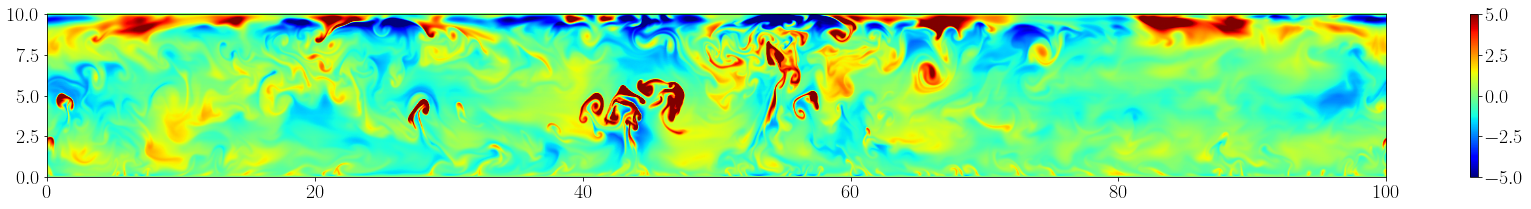

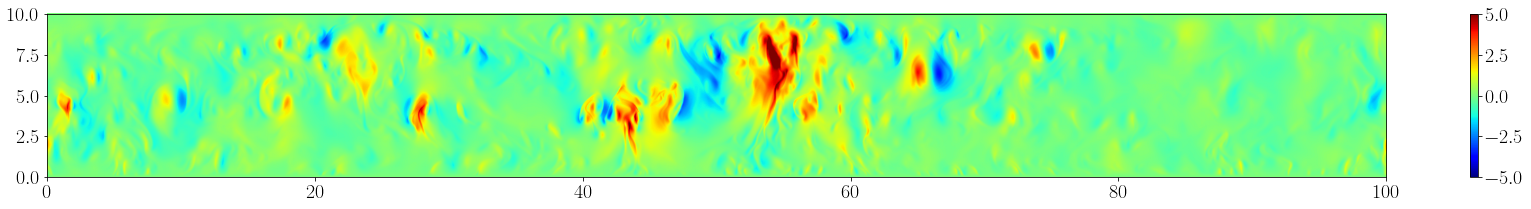

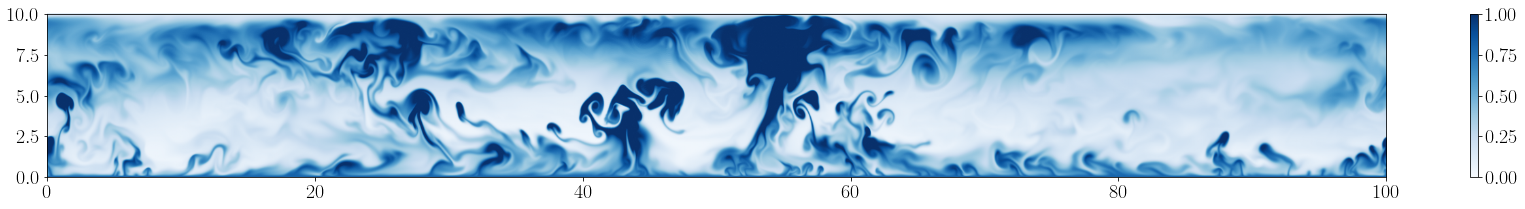

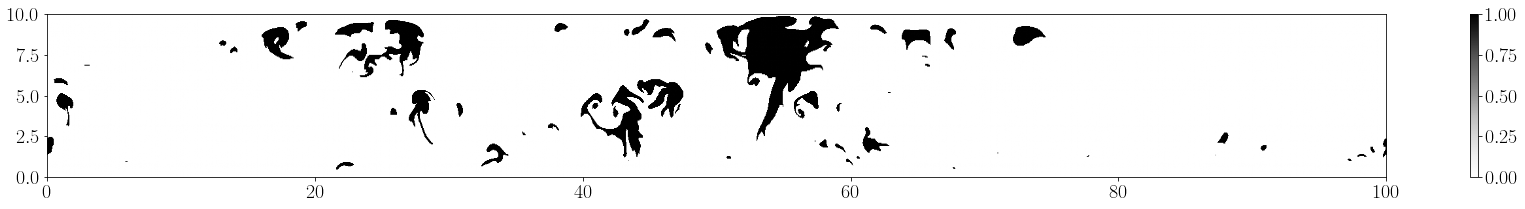

In [5]:
T_avg = np.average(T[0,:,:], axis = 0)
T_plumes = T[0,:,:] - T_avg

plt.figure(figsize = (30,3))
ax = plt.gca()
im = NonUniformImage(ax, interpolation = 'bilinear',extent=(0, Lx, 0, Lz),cmap='jet',norm = matplotlib.colors.Normalize(vmin=-5, vmax=5,clip=False))
im.set_data(xax,zax,np.transpose(T_plumes[:,:]))
ax.add_image(im)
ax.set_xlim(0, Lx)
ax.set_ylim(0, Lz)
colorbar(im)
# plt.savefig( "snapshots_Images/snapshot_T")
plt.show()

plt.figure(figsize = (30,3))
ax = plt.gca()
im = NonUniformImage(ax, interpolation = 'bilinear',extent=(0, Lx, 0, Lz),cmap='jet',norm = matplotlib.colors.Normalize(vmin=-5, vmax=5,clip=False))
im.set_data(xax,zax,np.transpose(u[0,1,:,:]))
ax.add_image(im)
ax.set_xlim(0, Lx)
ax.set_ylim(0, Lz)
colorbar(im)
plt.show()

plt.figure(figsize = (30,3))
ax = plt.gca()
im = NonUniformImage(ax, interpolation = 'bilinear',extent=(0, Lx, 0, Lz),cmap='Blues',norm = matplotlib.colors.Normalize(vmin=0, vmax=1,clip=False))
im.set_data(xax,zax,np.transpose(q[0,:,:]/qs[0,:,:]))
ax.add_image(im)
ax.set_xlim(0, Lx)
ax.set_ylim(0, Lz)
colorbar(im)
# plt.savefig('snapshots_Images/snapshot_q')
plt.show()

plt.figure(figsize = (30,3))
ax = plt.gca()
im = NonUniformImage(ax, interpolation = 'bilinear',extent=(0, Lx, 0, Lz),cmap='Greys',norm = matplotlib.colors.Normalize(vmin=0, vmax=1,clip=False))
im.set_data(xax,zax,np.transpose(q[0,:,:]/qs[0,:,:])>0.95)
ax.add_image(im)
ax.set_xlim(0, Lx)
ax.set_ylim(0, Lz)
colorbar(im)
# plt.savefig('snapshots_Images/snapshot_cloud_95')
plt.show()

In [6]:
### Grid definition

Agrid = np.zeros((Nx,Nz))
dx = xax[1] - xax[0]
for kx in range(0,Nx):
    for kz in range(1,Nz-1):
        dz1 = zax[kz+1] - zax[kz]
        dz2 = zax[kz] - zax[kz-1]
        Agrid[kx,kz] = dx*(dz1+dz2)*0.5
    Agrid[kx,0] = dx*((zax[1] - zax[0])*0.5+zax[0])
    Agrid[kx,Nz-1] = dx*((zax[Nz-1] - zax[Nz-2])*0.5+(Lz-zax[Nz-1]))

### Definition of derivation functions

def rms(A,Agrid):
    val = np.sqrt(np.sum(A**2*Agrid)/np.sum(Agrid))
    return val

def diffz(a,zax):
    nxx = np.shape(a)[0]
    nzz = np.shape(a)[1]
    if (nzz!=len(zax)):
        print("Lengths don't match")
        return False
    else:
        val = np.zeros((nxx,nzz))
        Dz_line = np.reshape(zax[1:Nz] - zax[0:Nz-1],(1,nzz-1))
        Dz_grid = np.matmul(np.ones((nxx,1)),Dz_line)
        
        a_suiv = a[:,2:Nz]
        a_mid  = a[:,1:Nz-1]
        a_prec = a[:,0:Nz-2]
        val[:,1:Nz-1] = (1/2)*((a_suiv - a_mid)/Dz_grid[:,1:Nz-1] + (a_mid - a_prec)/Dz_grid[:,0:Nz-2])

        a_deb_suiv = a[:,1]
        a_deb_mid  = a[:,0]
        val[:,0]      = (a_deb_suiv - a_deb_mid)/Dz_grid[:,0]
        
        a_fin_mid  = a[:,Nz-1]
        a_fin_prec = a[:,Nz-2]
        val[:,Nz-1]   = (a_fin_mid - a_fin_prec)/Dz_grid[:,Nz-2]
        
        return val

def diffx(a,xax):
    nxx = np.shape(a)[0]
    nzz = np.shape(a)[1]
    if (nzz!=len(zax)):
        print("Lengths don't match")
        return False
    else:
        dx = xax[1] - xax[0]    
        a_suiv_x = np.roll(a,-1,axis = 0)
        a_prec_x = np.roll(a,1,axis = 0)
        val = (a_suiv_x - a_prec_x)/(2*dx)
    return val

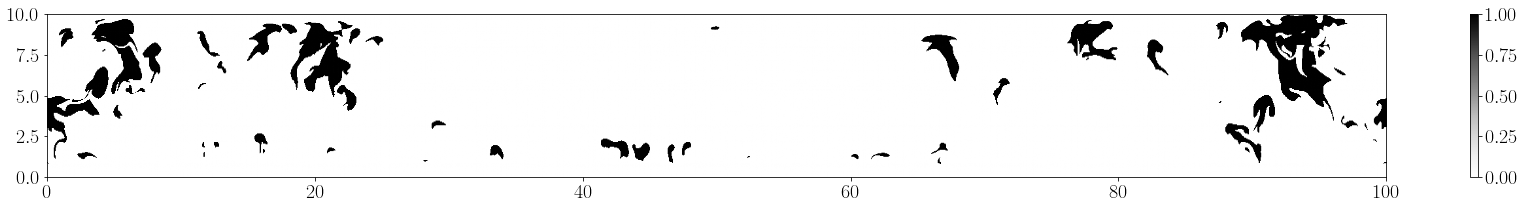

t =  2550.0


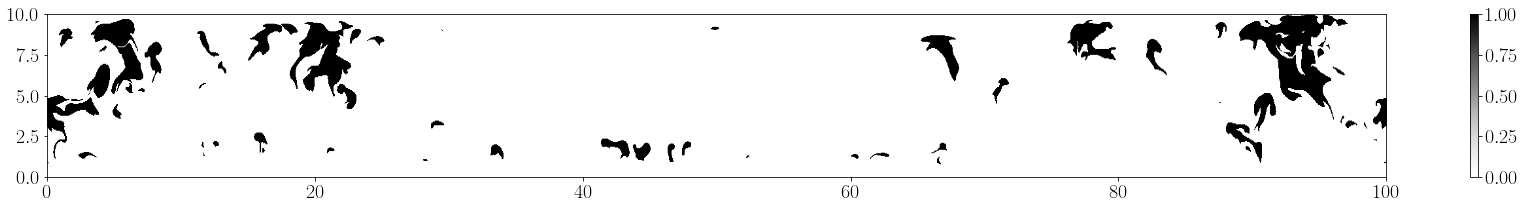

t =  0.05


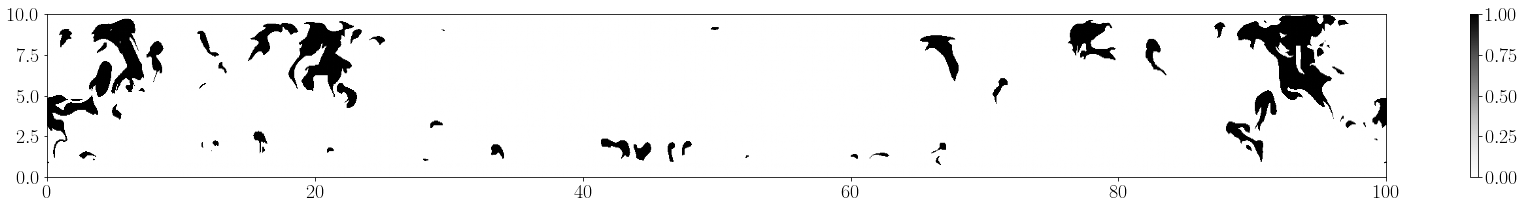

t =  0.05


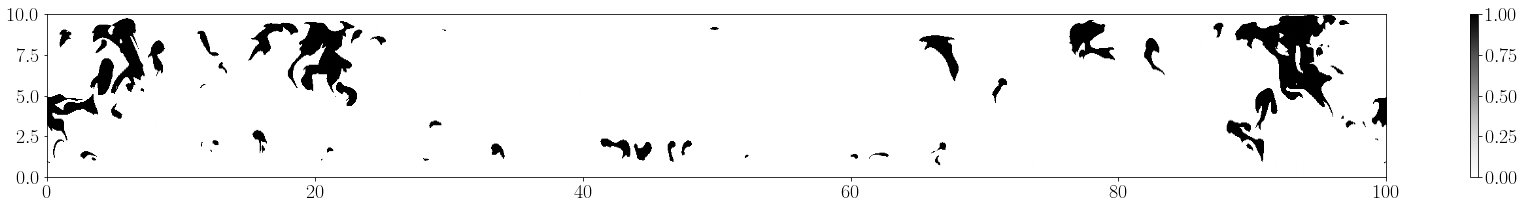

t =  0.05


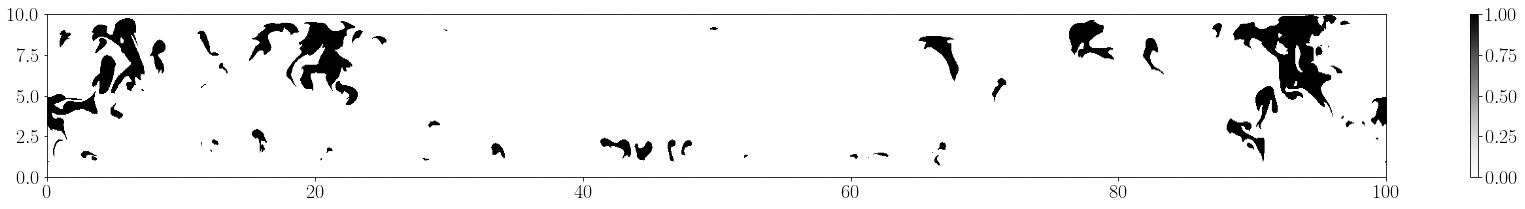

t =  0.05


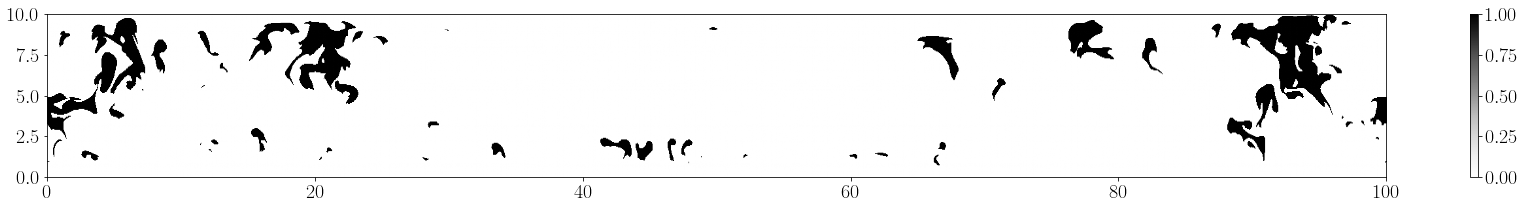

t =  0.05


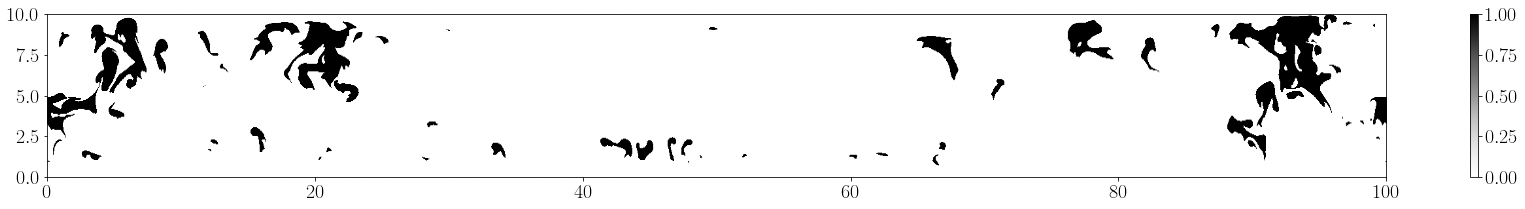

t =  0.05


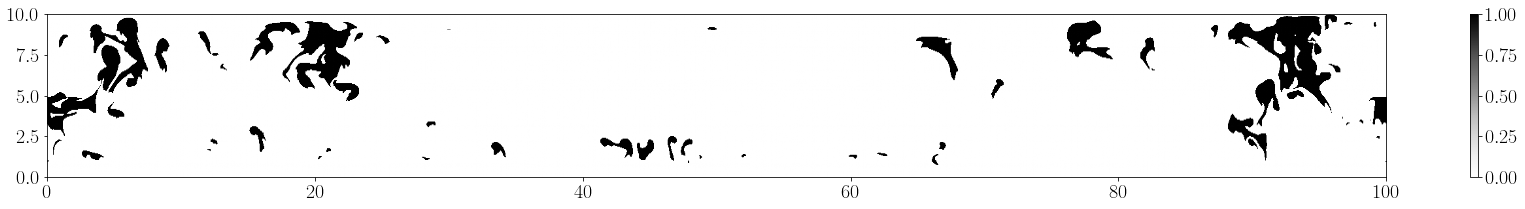

t =  0.05


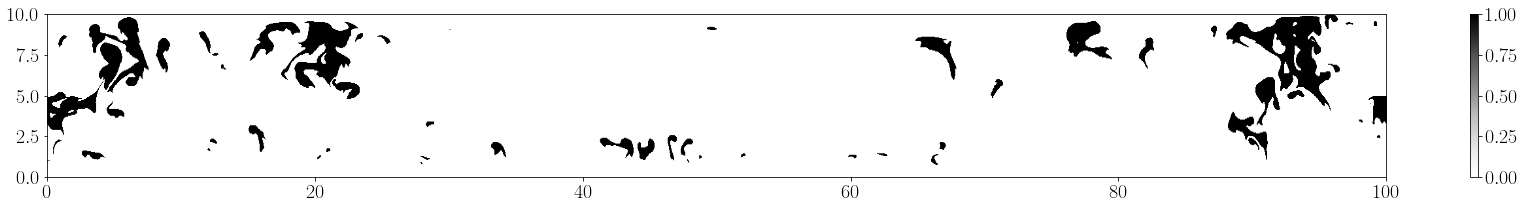

t =  0.05


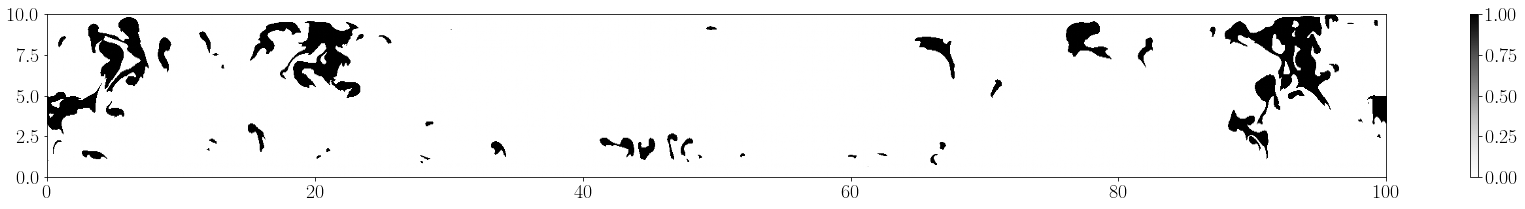

t =  0.05


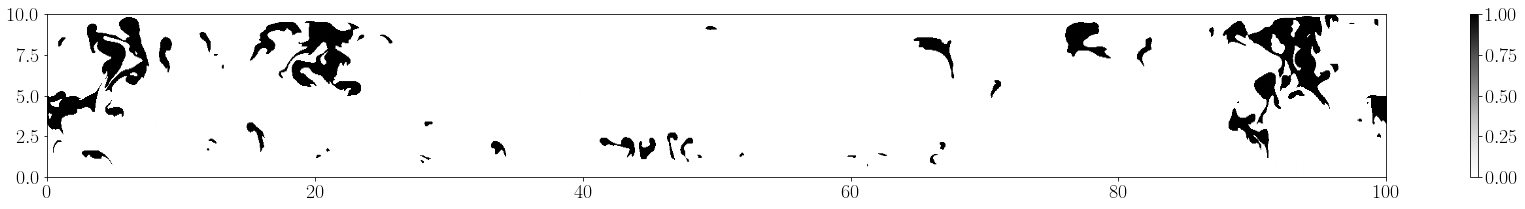

t =  0.05


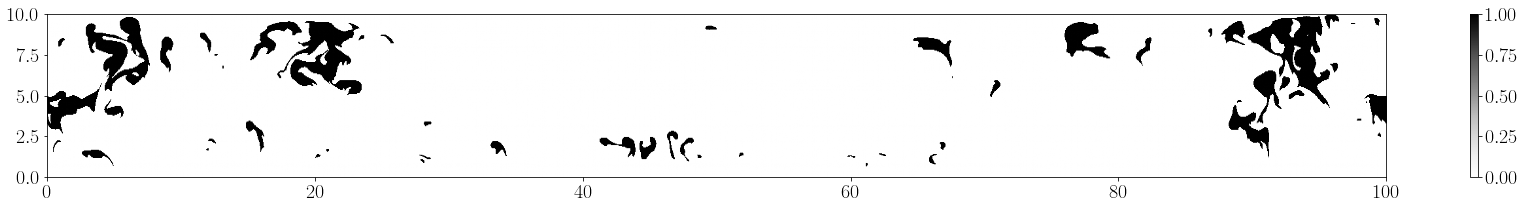

t =  0.05


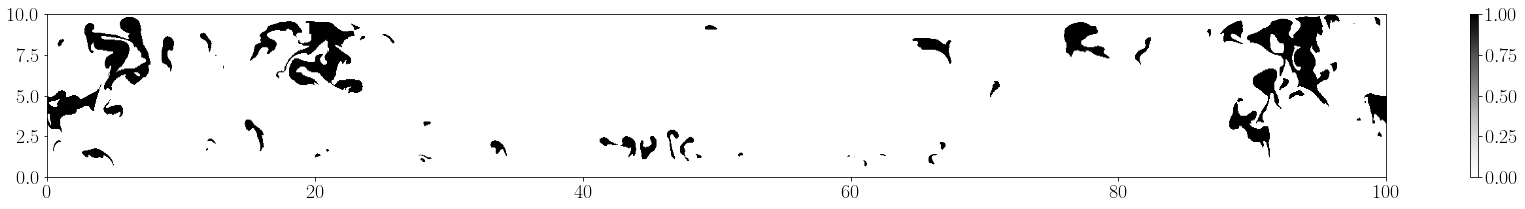

t =  0.05


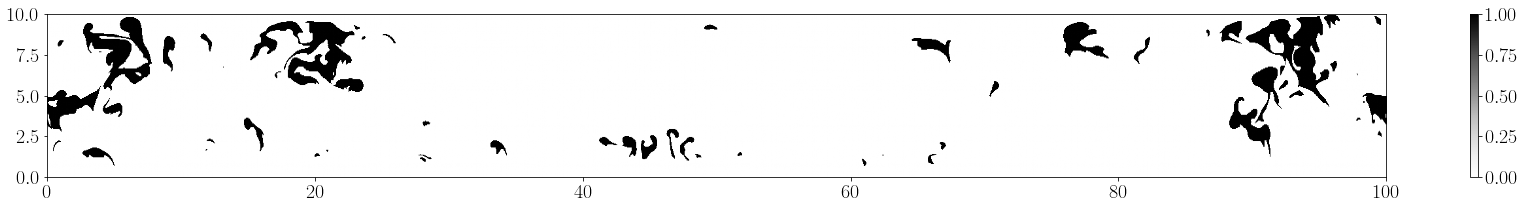

t =  0.05


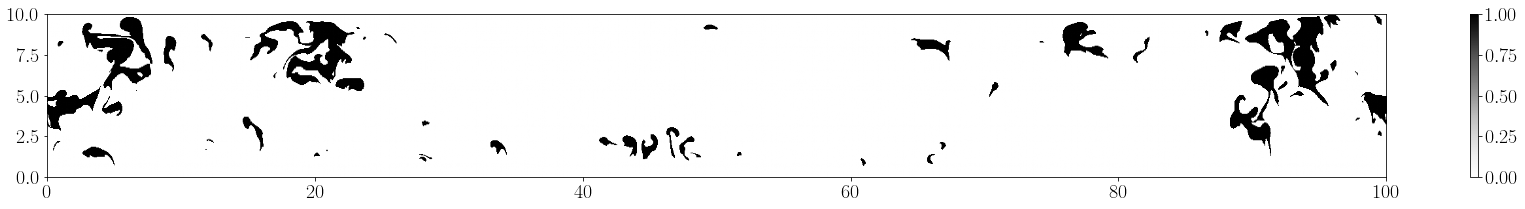

t =  0.05


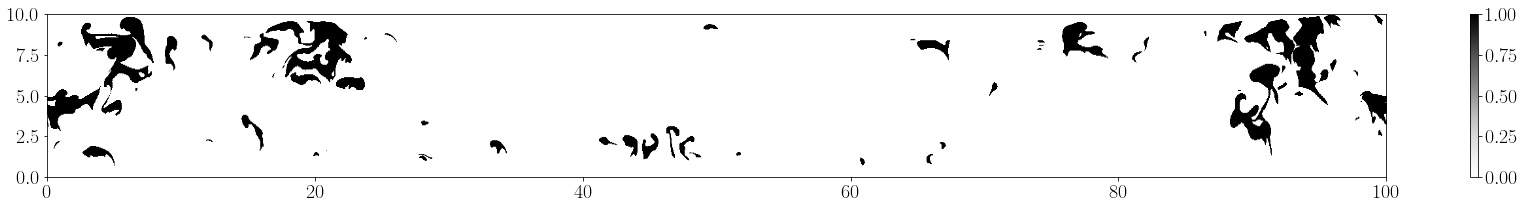

t =  0.05


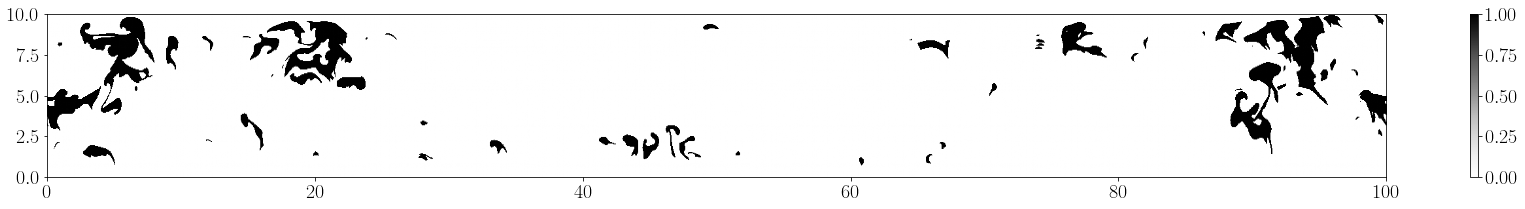

t =  0.05


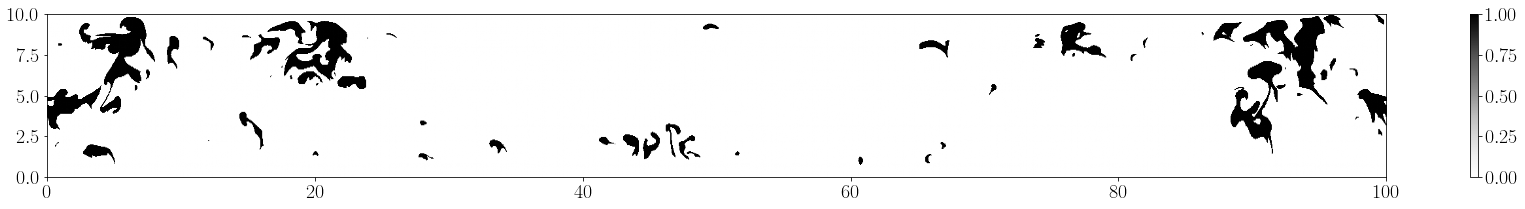

t =  0.05


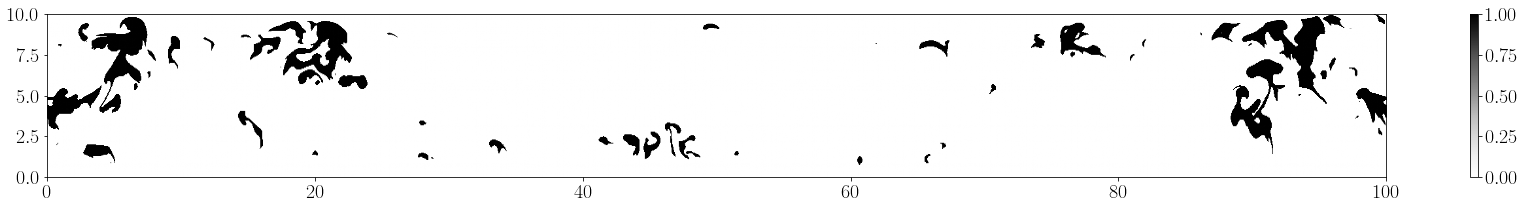

t =  0.05


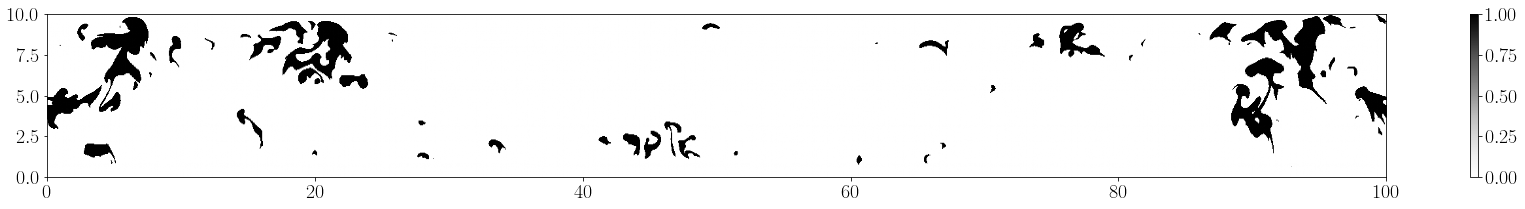

t =  0.05


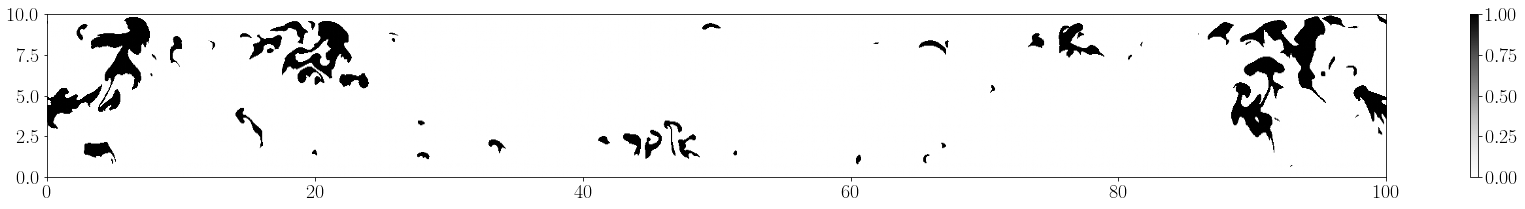

t =  0.05


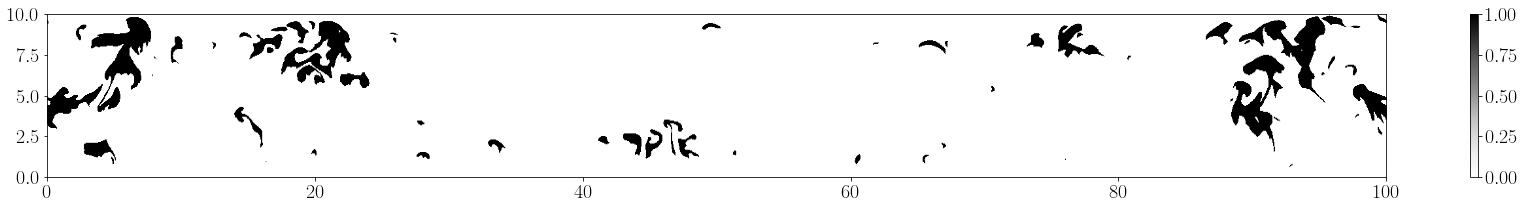

t =  0.05


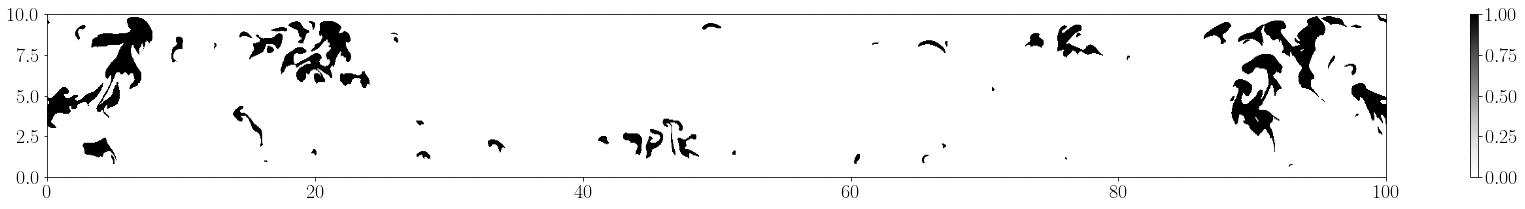

t =  0.05


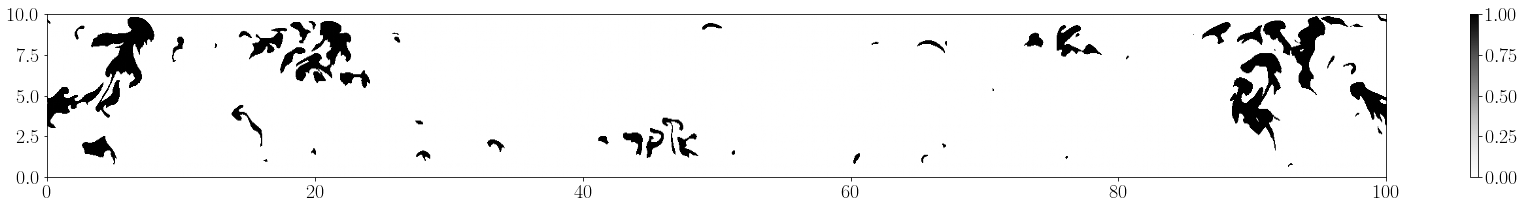

t =  0.05


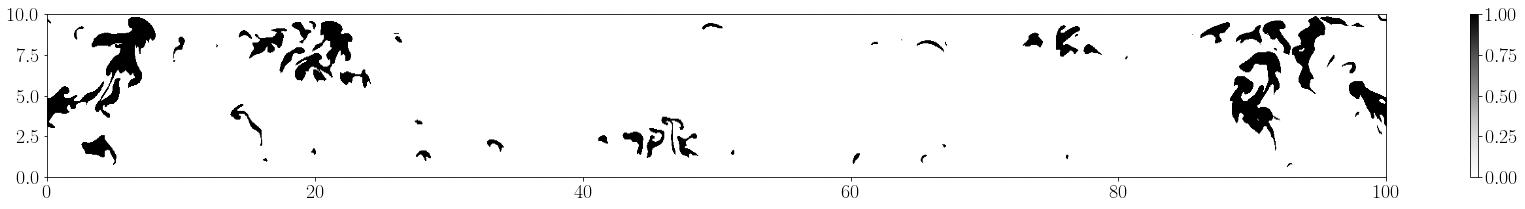

t =  0.05


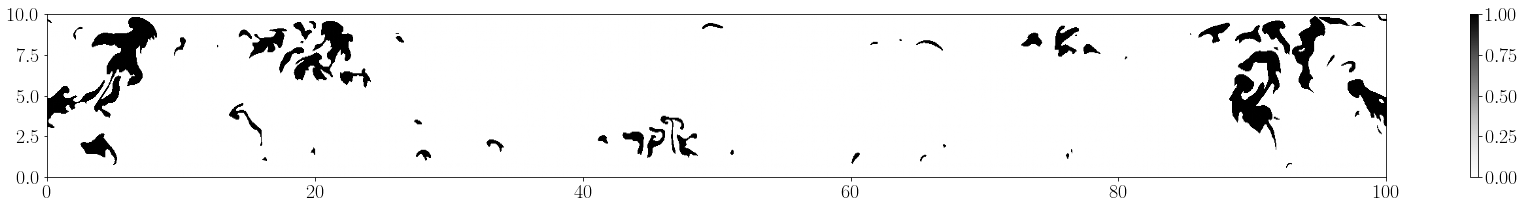

t =  0.05


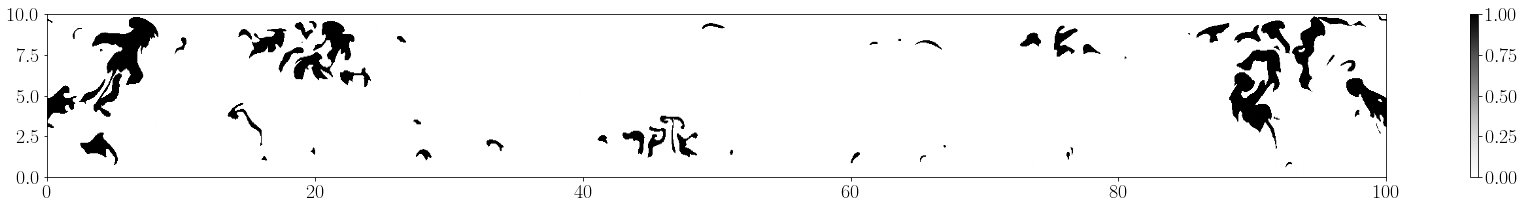

t =  0.05


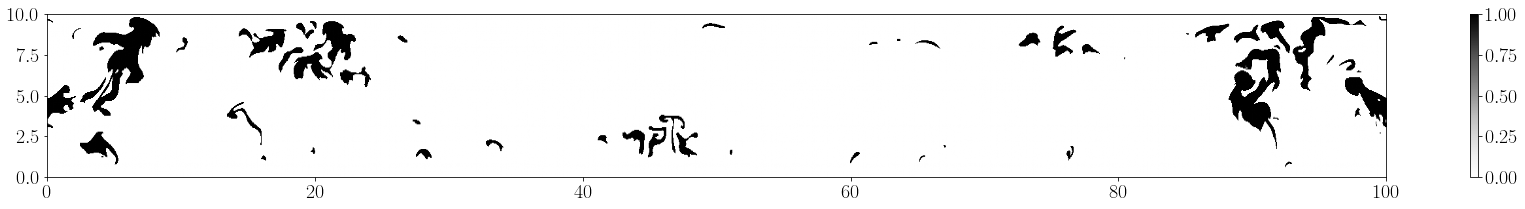

t =  0.05


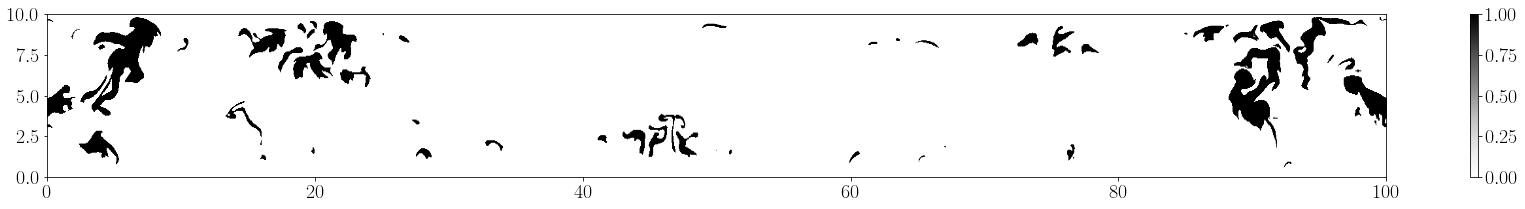

t =  0.05


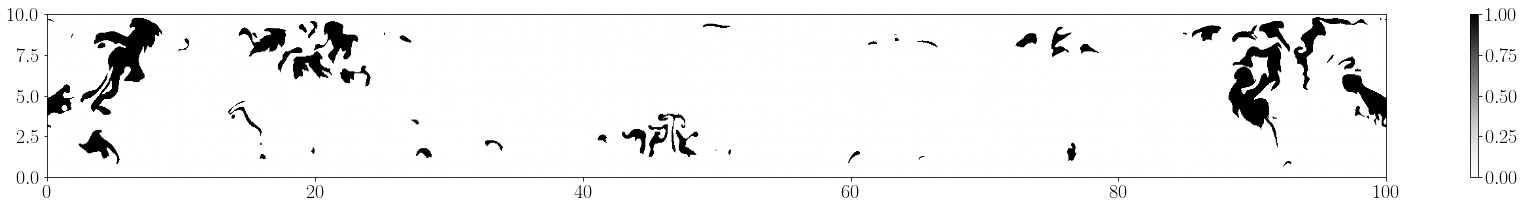

t =  0.05


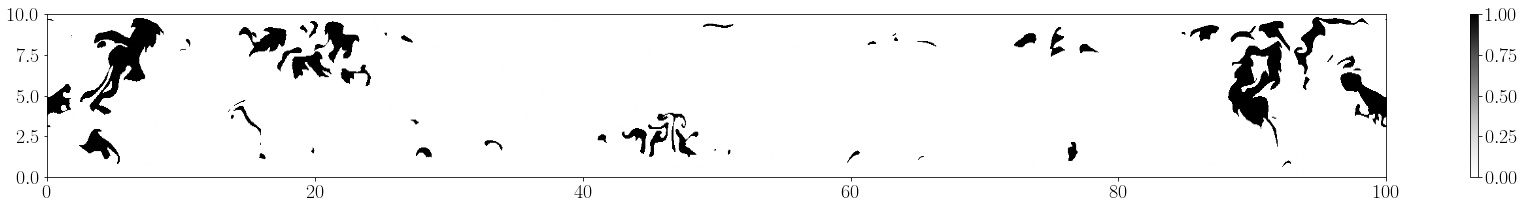

t =  0.05


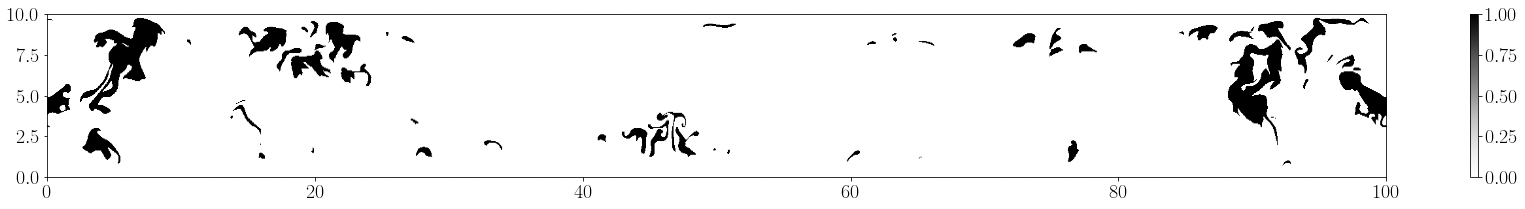

t =  0.05


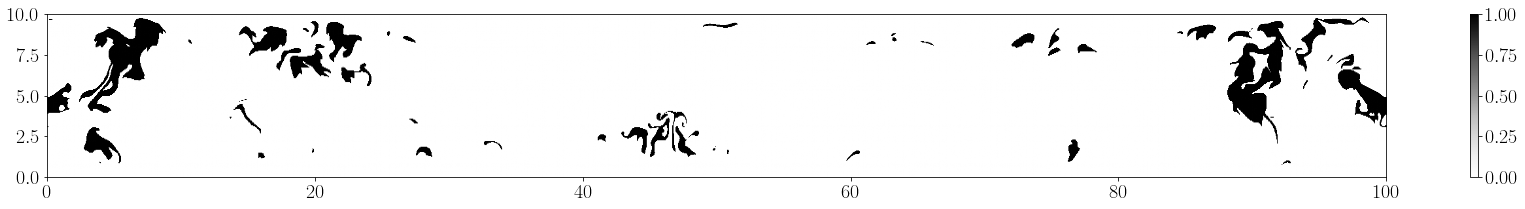

t =  0.05


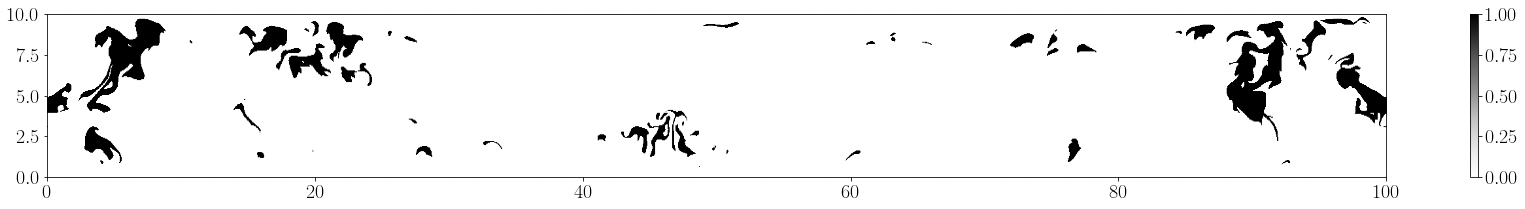

t =  0.05


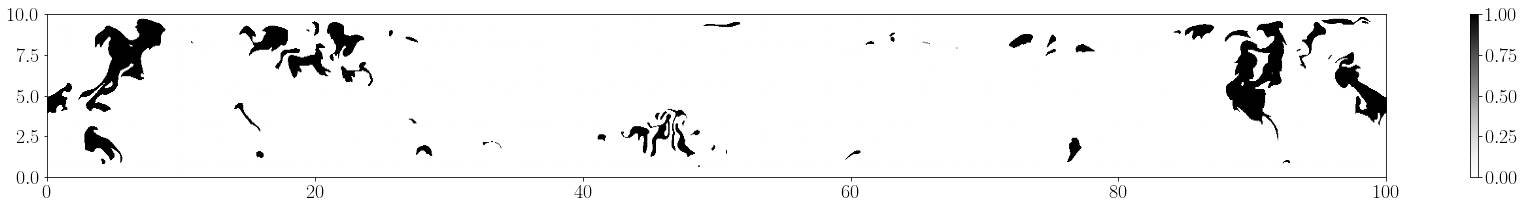

t =  0.05


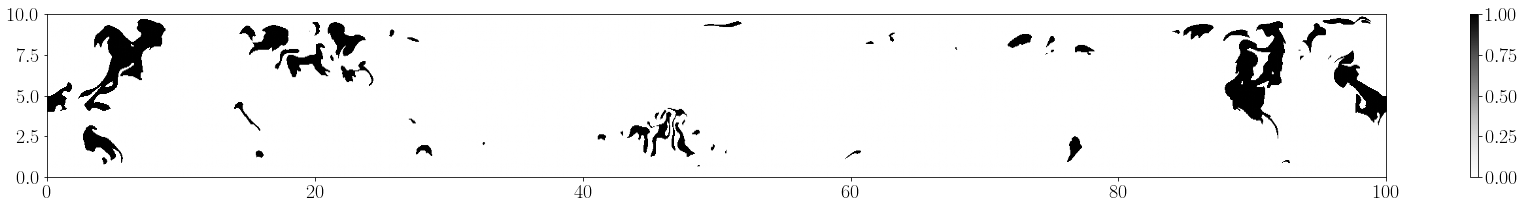

t =  0.05


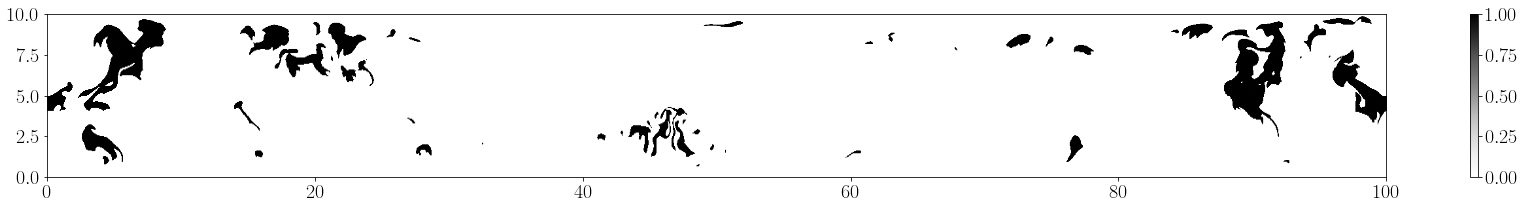

t =  0.05


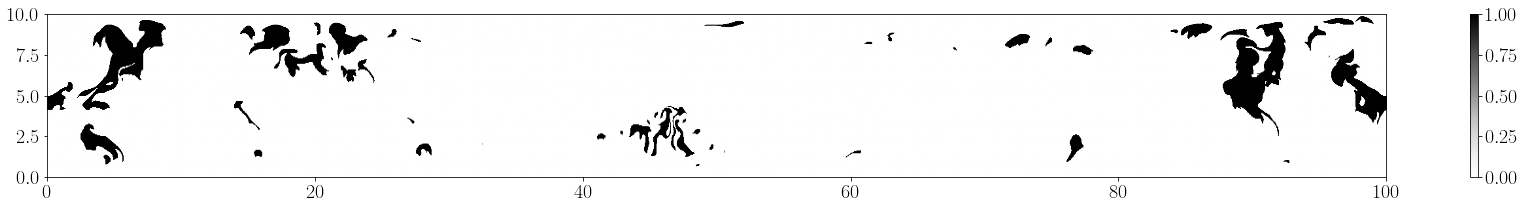

t =  0.05


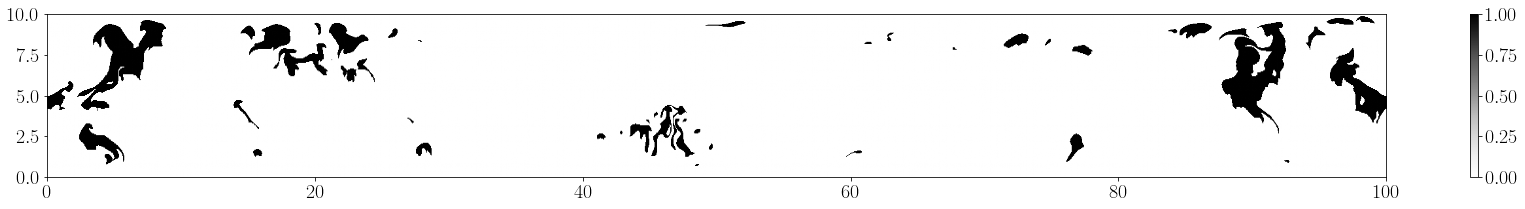

t =  0.05


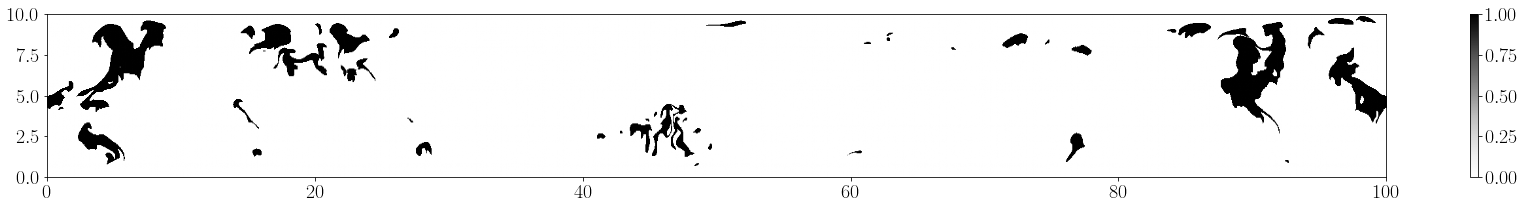

t =  0.05


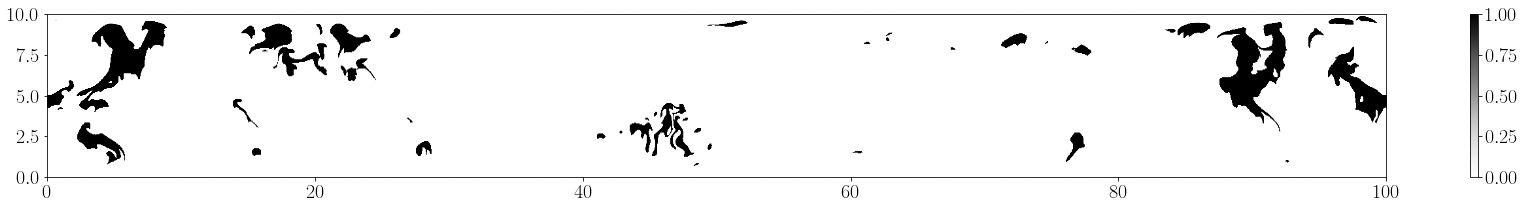

t =  0.05


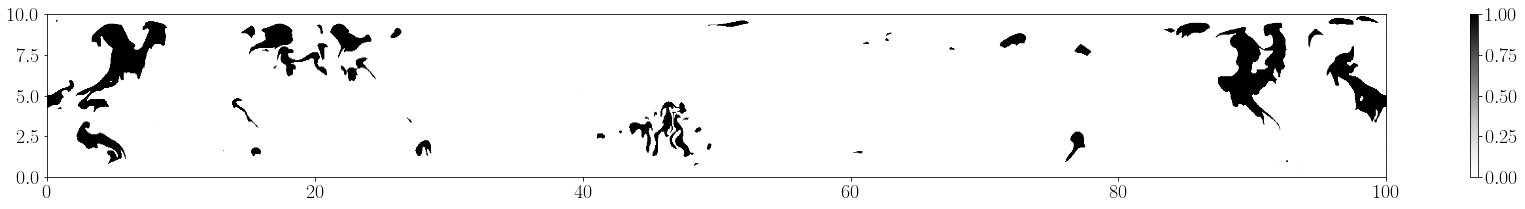

t =  0.05


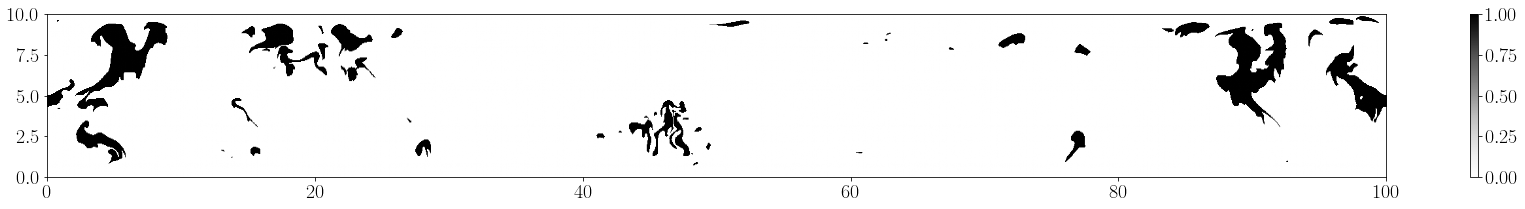

t =  0.05


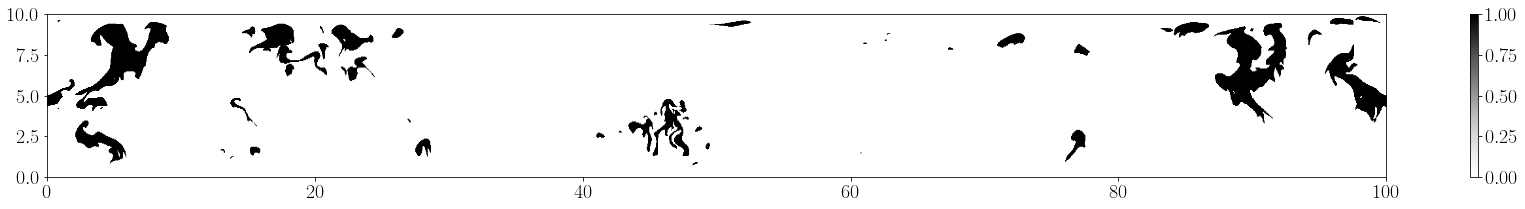

t =  0.05


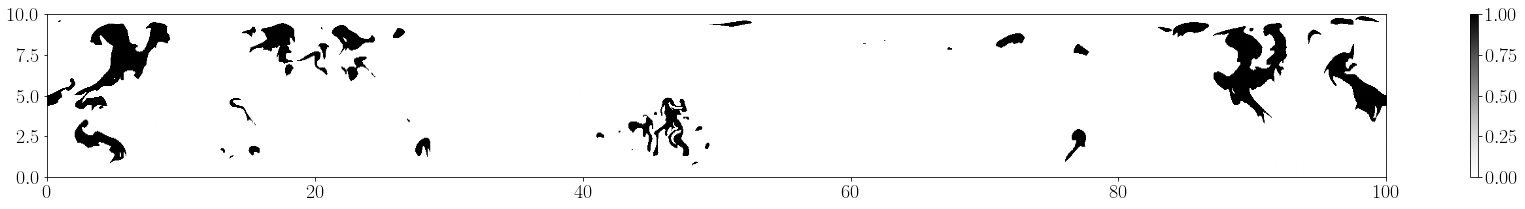

t =  0.05


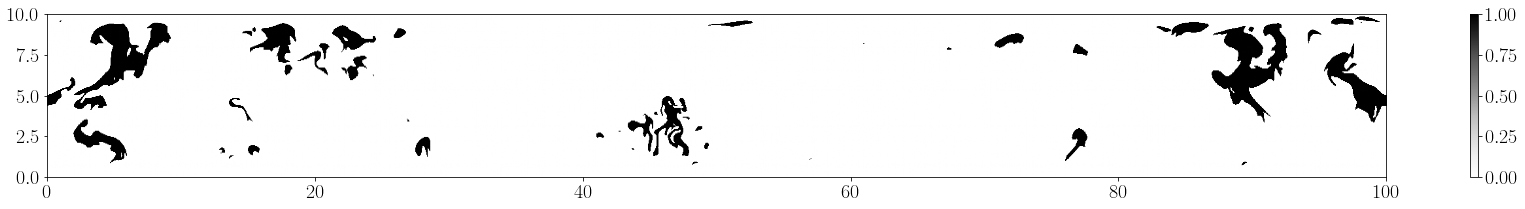

t =  0.05


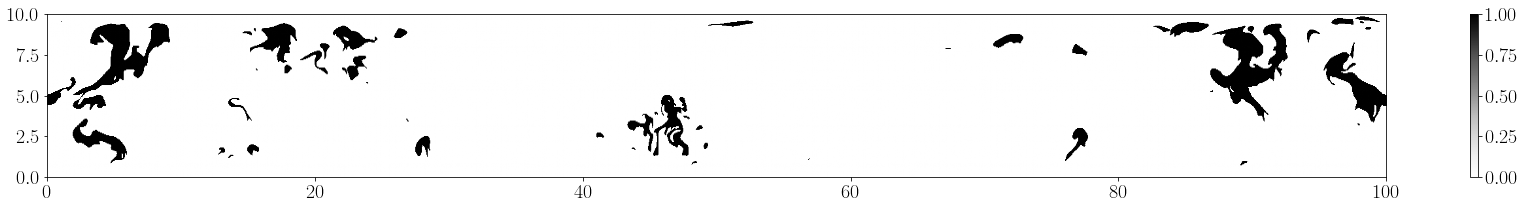

t =  0.05


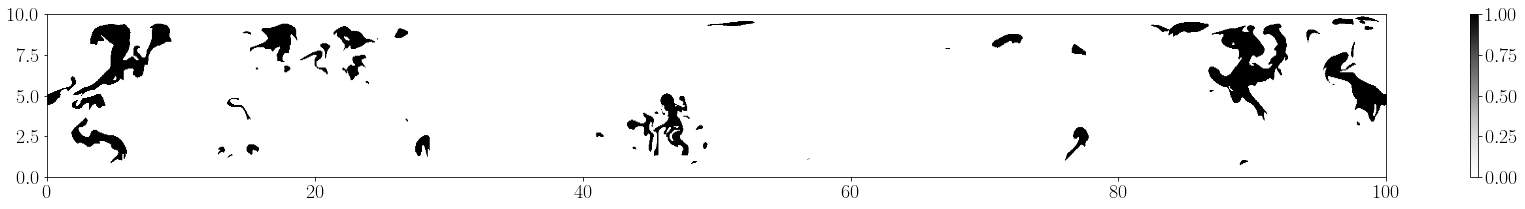

t =  0.05


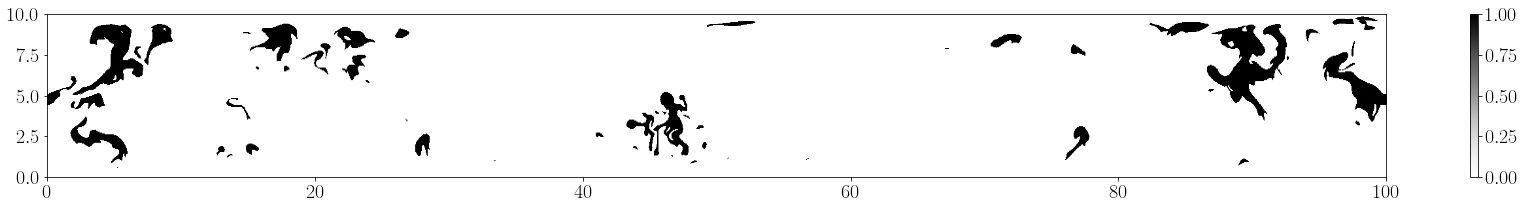

t =  0.05


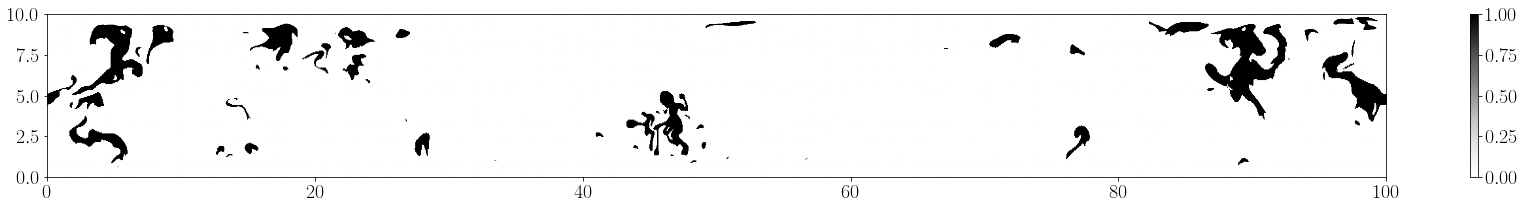

t =  0.05


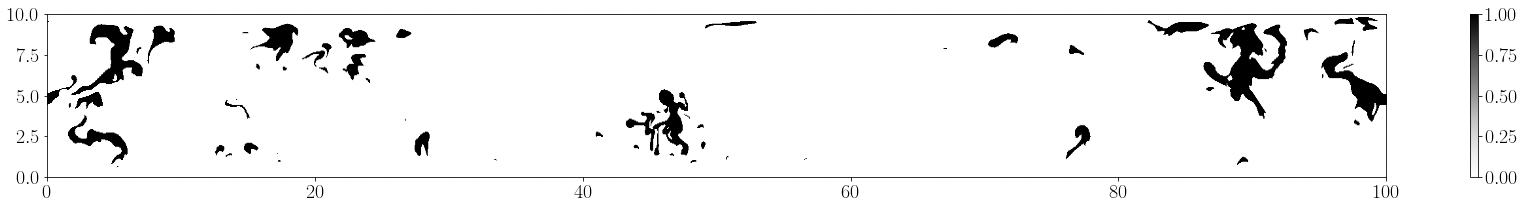

t =  0.05


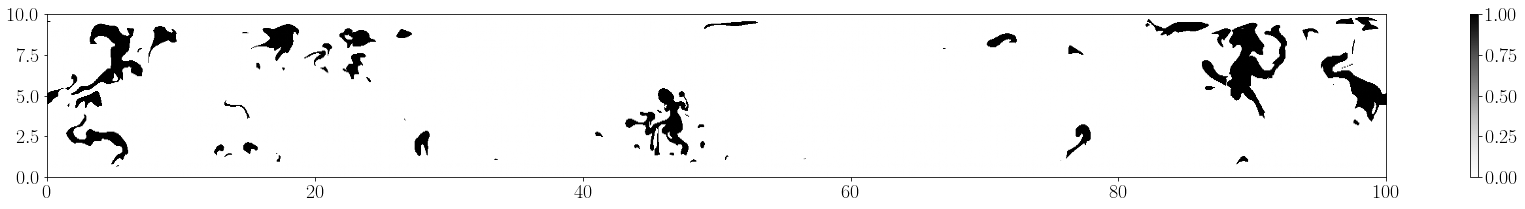

t =  0.05


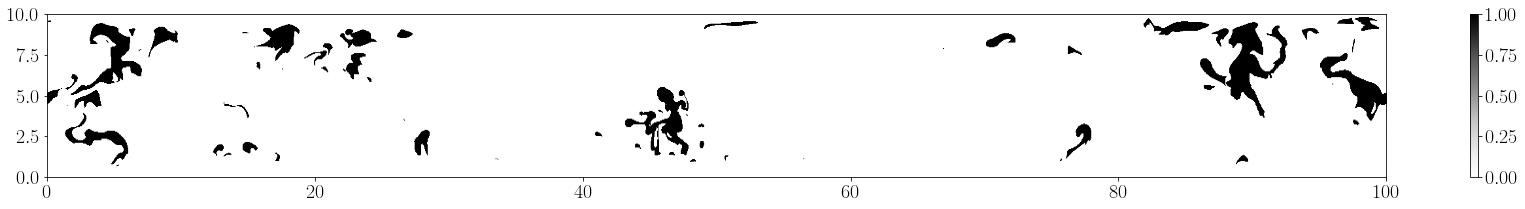

t =  0.05


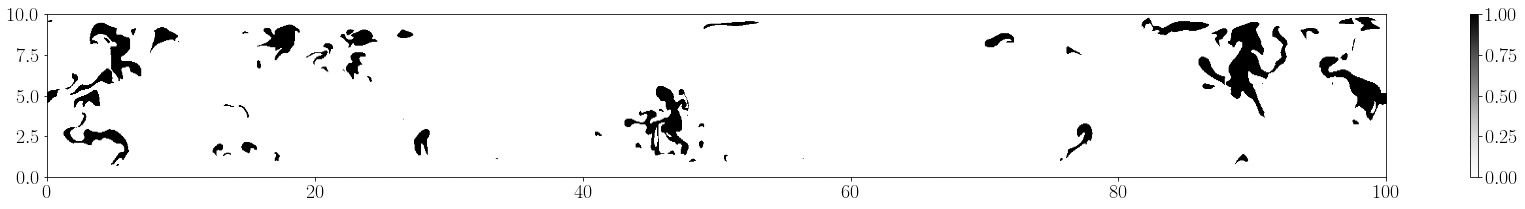

t =  0.05


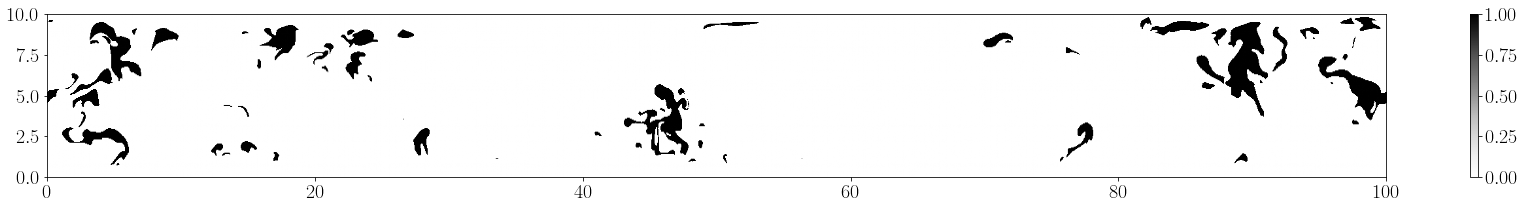

t =  0.05


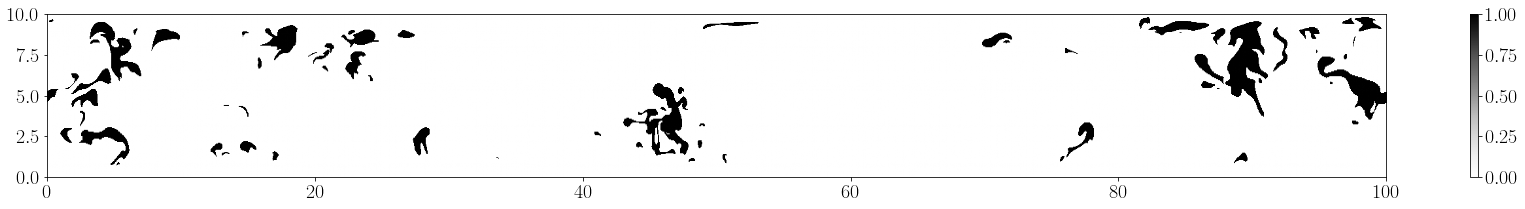

t =  0.05


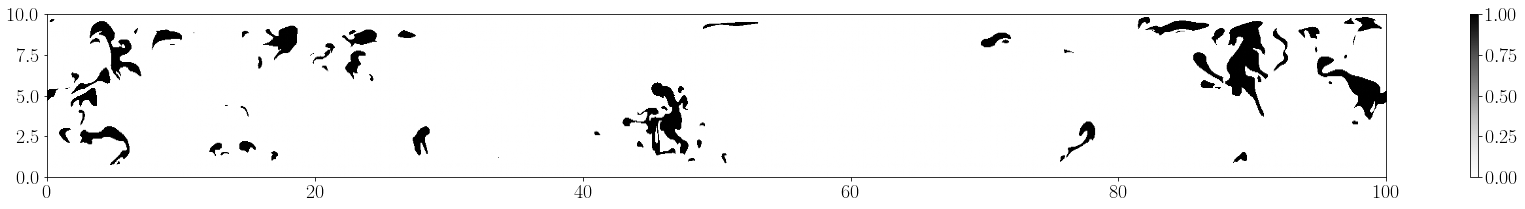

t =  0.05


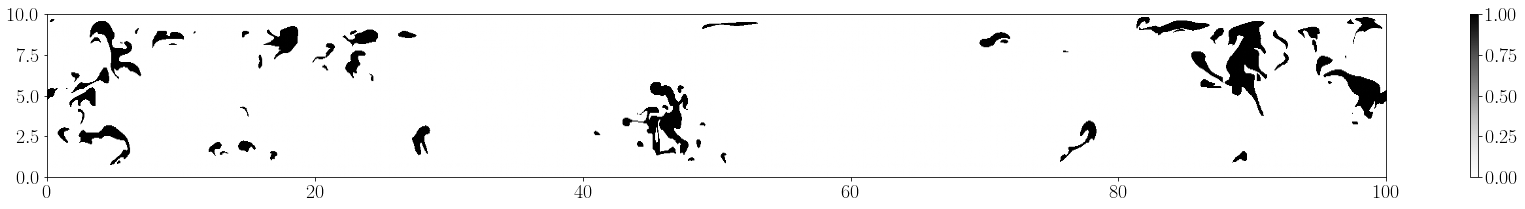

t =  0.05


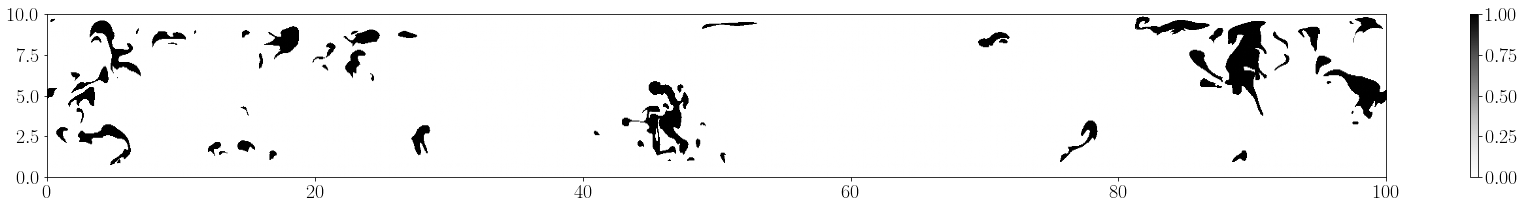

t =  0.05


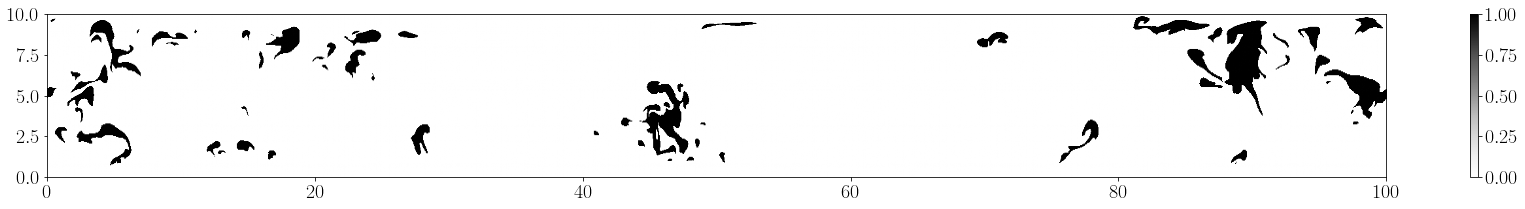

t =  0.05


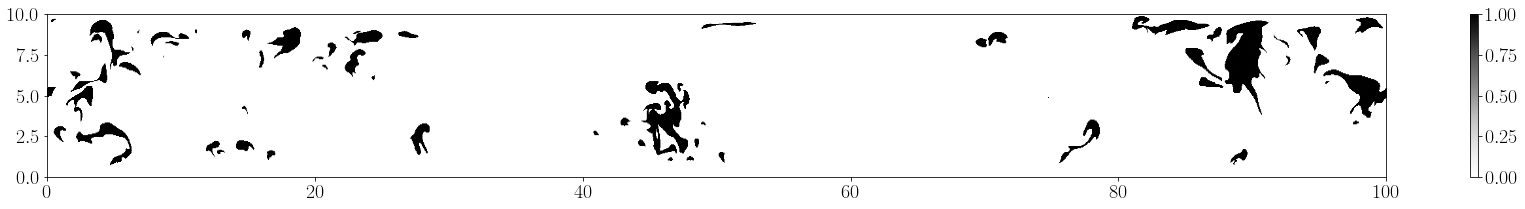

t =  0.05


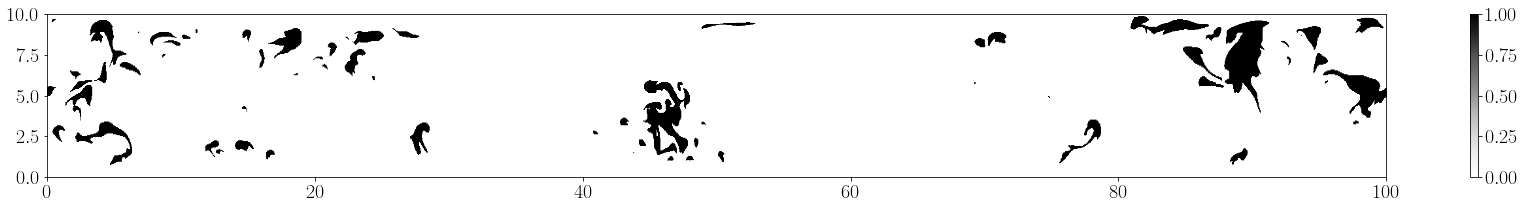

t =  0.05


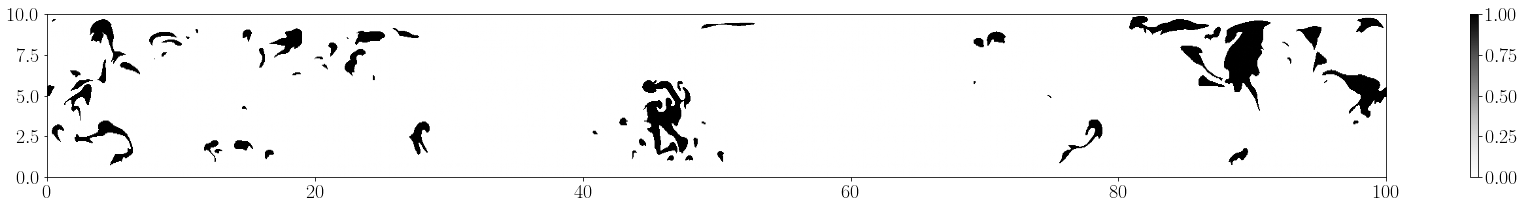

t =  0.05


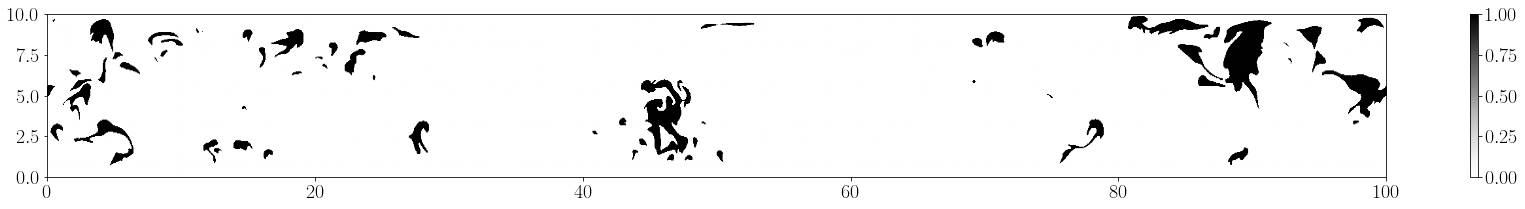

t =  0.05


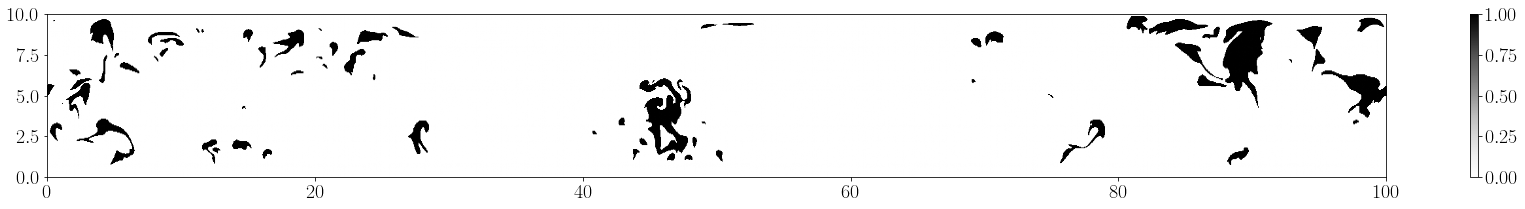

t =  0.05


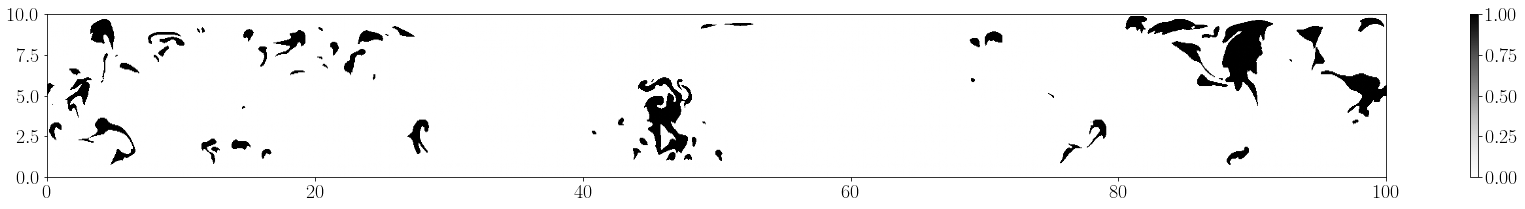

t =  0.05


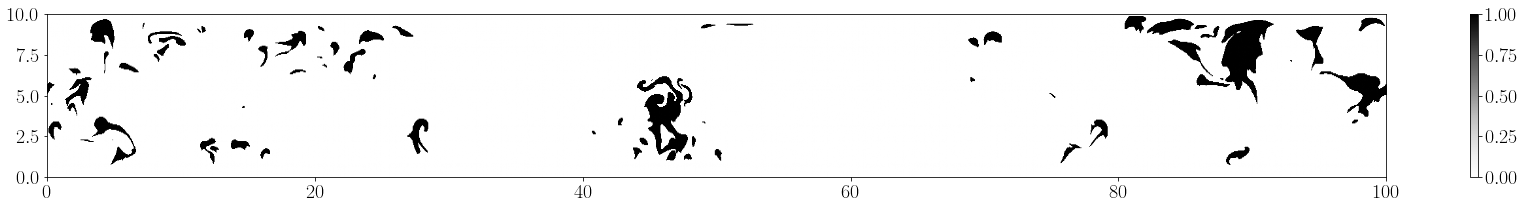

t =  0.05


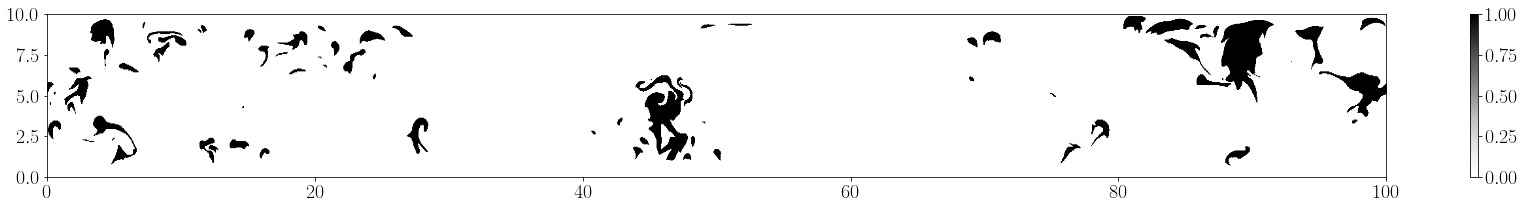

t =  0.05


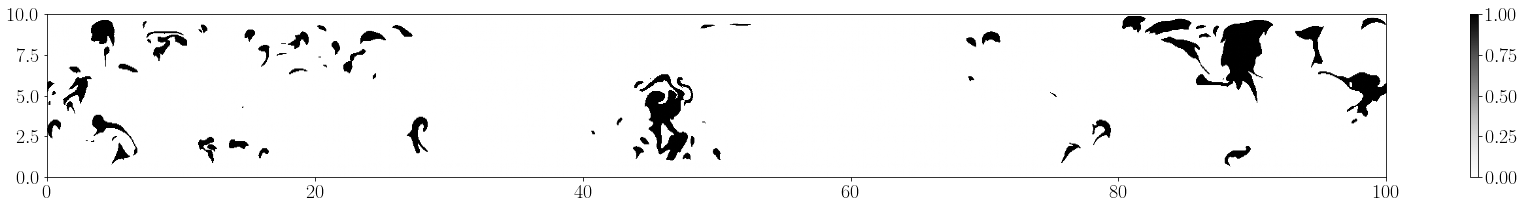

t =  0.05


KeyboardInterrupt: 

In [7]:
folder = "/nfs/scistore16/mullegrp/lagasthy/Moist_Rad/2D/fTfQ_atmos_varyingR/R_0p15_freqsnaps/"

t_prec = 0
t_suiv = 0
for n in range(1,20):
    fname = folder + "snapshots/snapshots_s" + str(n) + ".h5"
    
    f = h5py.File(fname,"r")
    T = np.array(f['tasks']['T'])
    q = np.array(f['tasks']['q'])
    qs = 25*np.exp(0.05516*(T-300))
    sim_times = np.array(f['scales']['sim_time'])
    Mmax = np.shape(T)[0]
    for m in range(Mmax):
        plt.figure(figsize = (30,3))
        ax = plt.gca()
        im = NonUniformImage(ax, interpolation = 'bilinear',extent=(0, Lx, 0, Lz),cmap='Greys',norm = matplotlib.colors.Normalize(vmin=0, vmax=1,clip=False))
        im.set_data(xax,zax,np.transpose(q[m,:,:]/qs[m,:,:])>0.95)
        ax.add_image(im)
        ax.set_xlim(0, Lx)
        ax.set_ylim(0, Lz)
        colorbar(im)
        plt.show()

        t_suiv = sim_times[m]
        print("t = ", round(t_suiv - t_prec,2))
        t_prec = sim_times[m]
print("finito")